In [17]:
# 네이버 광고 크롤링 
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from webdriver_manager.chrome import ChromeDriverManager
import time
import pandas as pd

# 크롬 옵션 설정 (최신 Headless 모드)
chrome_options = Options()
chrome_options.add_argument("--headless=new") 
chrome_options.add_argument("--disable-gpu")
chrome_options.add_argument("--window-size=1920,1080")
chrome_options.add_argument("--lang=ko-KR")
chrome_options.add_argument("--no-sandbox")
chrome_options.add_argument("--disable-dev-shm-usage")

# 드라이버 실행
driver = webdriver.Chrome(
    service=Service(ChromeDriverManager().install()),
    options=chrome_options
)

# 수집할 유튜브 URL
url = "https://youtu.be/-TZmHA6q2KU?si=702zXectFh4ZSCo3"
driver.get(url)

# 페이지 로딩 대기
time.sleep(5)

# 스크롤을 여러 번 내려서 댓글 로딩
last_height = driver.execute_script("return document.documentElement.scrollHeight")

for _ in range(10):
    driver.execute_script("window.scrollTo(0, document.documentElement.scrollHeight);")
    time.sleep(2)
    new_height = driver.execute_script("return document.documentElement.scrollHeight")
    if new_height == last_height:
        break
    last_height = new_height

# 댓글 요소들 수집
comments = driver.find_elements(By.ID, "comment")

data = []
for comment in comments:
    try:
        author = comment.find_element(By.ID, "author-text").text.strip()
    except:
        author = None

    try:
        content = comment.find_element(By.ID, "content-text").text.strip()
    except:
        content = None

    data.append({
        "작성자": author,
        "댓글": content
    })

# 드라이버 종료
driver.quit()

df = pd.DataFrame(data)
df.to_excel("naver_series_comments.xlsx", index=False, engine='openpyxl')
print("저장 완료")


저장 완료


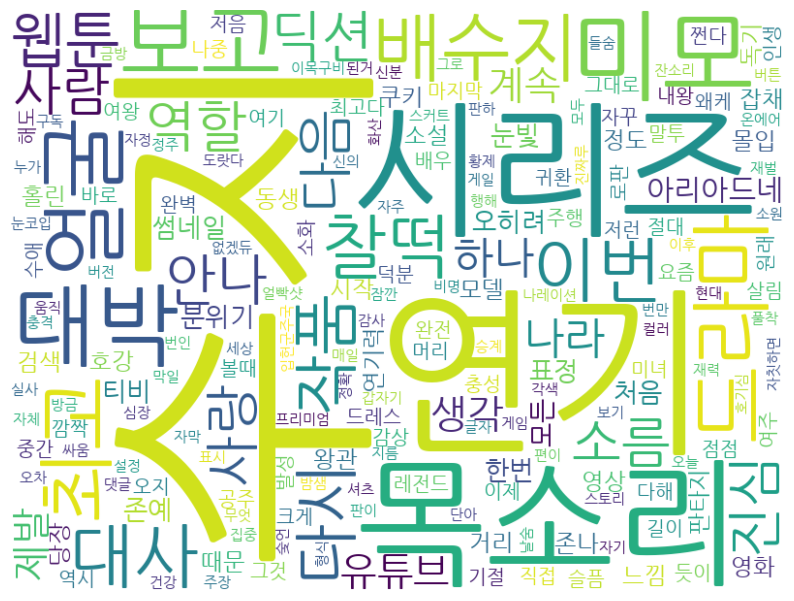

In [23]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from konlpy.tag import Okt

df = pd.read_excel("naver_series_comments.xlsx")

# '작성자' 말고 '댓글' 컬럼 내용만 모아서 하나의 문자열로 결합
text_data = df['댓글'].dropna().tolist()
text_all = " ".join(text_data)
okt = Okt()

# 명사만 추출
nouns = okt.nouns(text_all)

# 불용어 제거
stopwords = set([
    '그리고', '하지만', '이거', '그거', '저거',
    '있다', '하다', '되다', '이다', '에서',
    '합니다', '제가', '너무', '정말', '그냥', 
    '지금', '같아요', '근데', '이건', '거의',
    '보니', '거기', '우리', '해서', '네이버', '진짜', '광고', '언니', '왕비'
])
words = [word for word in nouns if word not in stopwords and len(word) > 1]

# 단어 빈도수 집계
from collections import Counter
word_freq = Counter(words)

# 워드클라우드 생성
wordcloud = WordCloud(
    font_path='NanumGothic.ttf',   
    background_color='white',
    width=800,
    height=600
).generate_from_frequencies(word_freq)

plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


In [24]:
# 상위 30개 단어 출력
top_words = word_freq.most_common(30)

for word, count in top_words:
    print(f"{word:<10} {count}")

수지         108
연기         29
시리즈        18
목소리        16
미모         16
대박         13
보고         12
얼굴         12
드라마        11
최고         10
배수지        10
찰떡         9
대사         9
이번         9
작품         8
다시         8
웹툰         8
역할         7
딕션         7
안나         7
진심         7
다음         7
사랑         7
소름         7
사람         7
나라         5
하나         5
유튜브        5
제발         5
생각         5


# '언니, 이번 생엔 내가 왕비야' 홍보 유튜브 영상 댓글 분석
* https://www.youtube.com/watch?v=-TZmHA6q2KU
* 네이버웹소설 연재 작품 
* 네이버 웹소설 지상최대 공모전 수상작
* 2023년 10월 기준 다운로드 횟수 5000만 돌파 작품

## 결과 분석
* 네이버 웹소설 **‘언니, 이번생엔 내가 왕비야’** 홍보 유튜브 영상의 댓글을 워드 클라우드 및 단어 빈도수 분석 결과, 가장 많이 언급된 단어는 **'수지'**(108회)로 나타났습니다. 이는 해당 영상에서 주연 배우로 등장한 수지에 대한 관심이 매우 높음을 보여줍니다. 단순히 작품 내용이나 웹소설 자체보다는, 수지의 출연이 소비자 혹은 시청자들의 흥미를 유발하는 주요 요소임을 시사합니다. 

* 또한  '연기', '목소리', '미모', '찰떡', '대박' 등의 단어가 상위권을 차지하고 있는 점은, 시청자들이 웹소설 자체가 아닌 웹소설 홍보 영상에서 만큼은 **줄거리나 세계관**보다는 배우의 **연기력, 외적인 이미지, 원작과의 싱크로율**에 더욱 관심을 보인다는 것을 알 수 있습니다.

* '최고', '대박', '보고', '찰떡'과 같은 긍정적 단어의 빈도도 높은 점으로 미루어 볼 때, 광고 영상이 대체로 긍정적인 반응을 얻고 있음을 추정할 수 있습니다.

* 드라마 형식으로 제작한 광고인데 배우의 '연기', '연기력', '드라마' 단어 빈도가 높게 측정되는 것으로 보아 작품의 2차 콘텐츠화 가능성에 대해서도 시청자들이 높은 관심을 보이고 있는 것으로 해석됩니다. 이는 **웹소설의 IP 확장**을 고려할 때 마케팅적으로 매우 긍정적인 신호로 볼 수 있습니다.